<a href="https://colab.research.google.com/github/saspav/python_for_pro/blob/main/%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='6'>**Практическая работа 2**</font>  
<font color='#11a642' size='5'>**Тема: Машинное обучение**</font>  
<font size='5'>**Задание:**</font>  


**Ваша задача** — предсказать, останется ли клиент с аккаунтом или закроет его (например, уйдёт).

Требования к оформлению:
- Работа должна быть оформлена в jupyter notebook (файл *.ipynb)
- Работа должна содержать комментарии и выводы. Объясняйте почему вы выбрали именно этот способ обработки данных


Всем удачи!





# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# <font color='#11a642' size='6'> **Загрузка данных**

In [2]:
try:
    url = 'https://drive.google.com/uc?id=1wvqGslWLauKyZxLY-d3RQCTyHCb5wJCO'
    df = pd.read_csv(url)
except:
    df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# Колонка "id" не несет смысла - это индекс
df.set_index("id", inplace=True)

In [5]:
# 2. Разделение признаков и целевой переменной
X = df.drop('Exited', axis=1)
y = df[['Exited']]

In [6]:
y.head()

,Exited
id,
0,0
1,0
2,0
3,0
4,0


## <font color='#11a642' size='5'> Напишите ответы на следующие вопросы: </font>


1.   К какому типу переменных относится целевой признак?
2.   Какую задачу машинного обучения вам предстоит решить, регрессия или классификация?

In [7]:
y.value_counts()

,count
Exited,
0,130113
1,34921


# ваш ответ
1. В целевом признаке только 2 целочисленных значения.
2. Таким образом мы будем решать задачу бинарной классификации.

# <font color='#11a642' size='6'> **Разведочный анализ данных**

## <font color='#11a642' size='5'> Оцените размер вашего датасета  </font>



1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [8]:
# Сколько ГБ ваш датасет
df.memory_usage(deep=True).sum() / 1024 ** 3

np.float64(0.04248335398733616)

In [9]:
# Сколько строк и столбцов
df.shape

(165034, 13)

In [10]:
# Дубликатов нет

df.duplicated().sum()

np.int64(0)

## <font color='#11a642' size='5'> Анализ числовых (непрерывных) признаков


- для каждого признака посчитайте минимум, максимум, среднее, медиану

In [11]:
# Выбираем числовые колонки
num_cols = X.select_dtypes(include=['number']).columns.tolist()
# Считаем требуемые статистики
X[num_cols].agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
CustomerId,15565701.00,15815690.00,1.569201e+07,15690169.0
CreditScore,350.00,850.00,6.564544e+02,659.0
Age,18.00,92.00,3.812589e+01,37.0
Tenure,0.00,10.00,5.020353e+00,5.0
Balance,0.00,250898.09,5.547809e+04,0.0
NumOfProducts,1.00,4.00,1.554455e+00,2.0
HasCrCard,0.00,1.00,7.539537e-01,1.0
IsActiveMember,0.00,1.00,4.977702e-01,0.0
EstimatedSalary,11.58,199992.48,1.125748e+05,117948.0


In [12]:
# Посмотрим на распределение у идентификаторам пользователей

df.CustomerId.value_counts()

,count
CustomerId,
15682355,121
15570194,99
15585835,98
15595588,91
15648067,90
...,...
15744577,1
15596817,1
15731021,1


У некоторых пользователей под сотню аккаунтов.

Колонка "CustomerId" не несет смысловой нагрузки - это идентификатор пользователя, уберем его из обучения.

In [13]:
num_cols.remove('CustomerId')
num_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

## <font color='#11a642' size='5'> Анализ категориальных признаков


- для каждого признака посчитайте моду, количество уникальных значений

In [14]:
# Выбираем категориальные колонки (включая строки и категории)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
X[cat_cols].agg([lambda z: z.mode().tolist()[0], 'nunique']).T.rename(columns={'<lambda>': 'mode'})

,mode,nunique
Surname,Hsia,2797
Geography,France,3
Gender,Male,2


In [15]:
# Колонка "Surname" не несет смысловой нагрузки, т.к. это имя
# с большим количеством уникальных значений уберем её из обучения

cat_cols.remove('Surname')
cat_cols

['Geography', 'Gender']

## <font color='#11a642' size='5'> Анализ целевого признака


- какая доля 1?

In [16]:
y.value_counts(normalize=True)[1] * 100

np.float64(21.159882206090867)

# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

- нужна ли стратификация?

In [17]:
# Т.к. у нас наблюдается дисбаланс классов: класс с меткой "1" всего 21%
# Будем делить со стратификацией

train, valid, X_train, X_valid, y_train, y_valid = train_test_split(df, X, y,
                                                                    test_size=0.2,
                                                                    stratify=y,
                                                                    random_state=127)

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

## Поиск и анализ выбросов

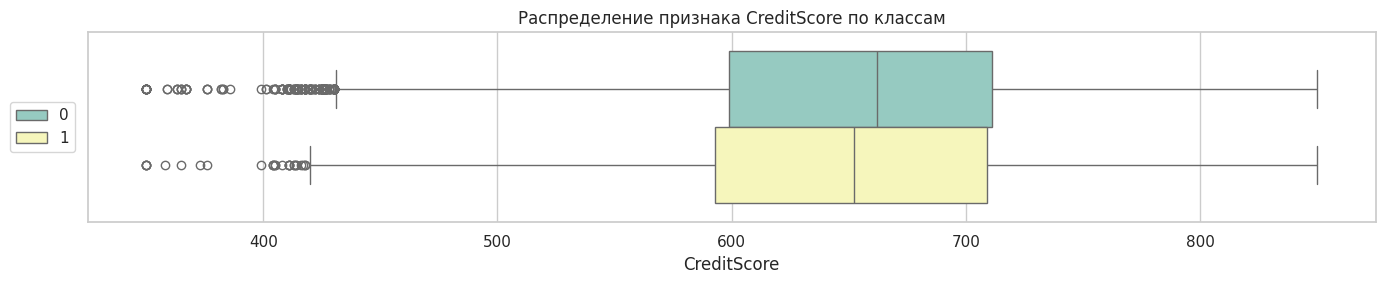

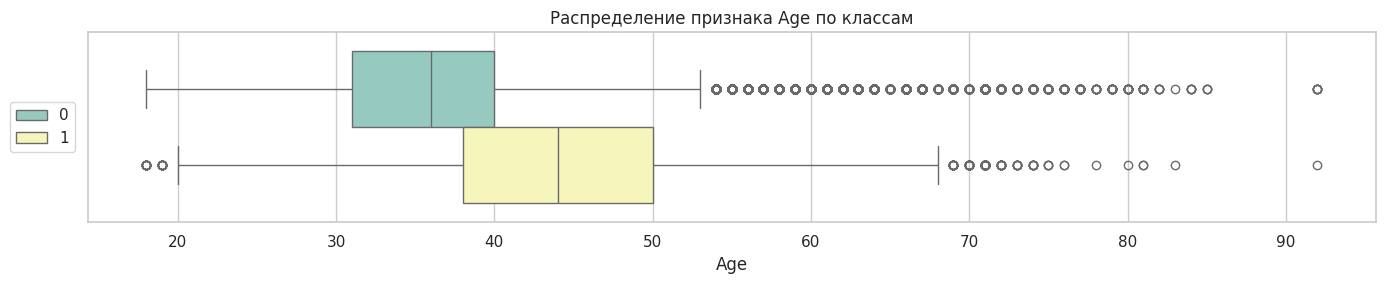

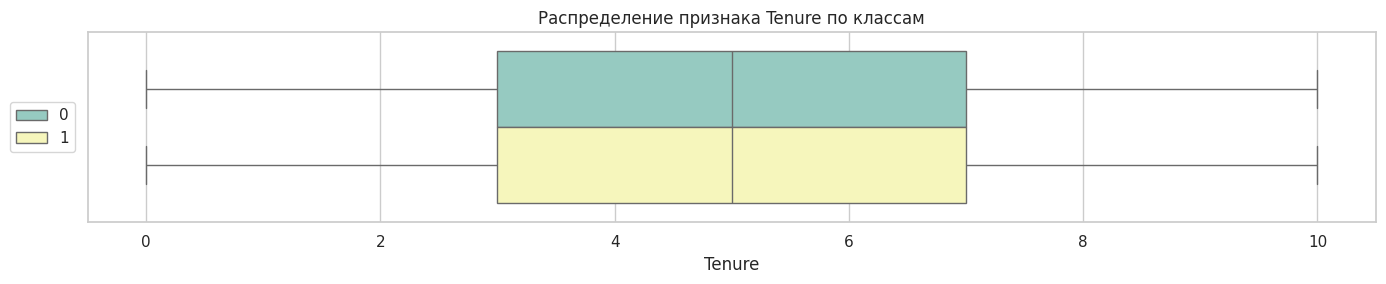

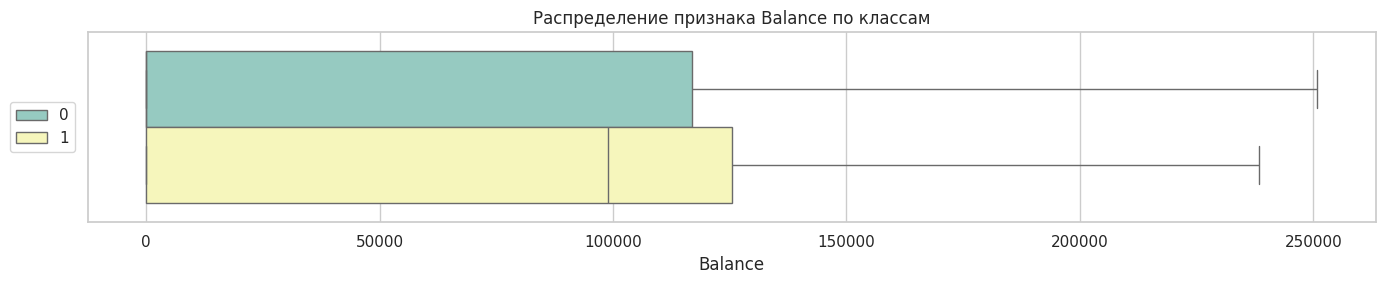

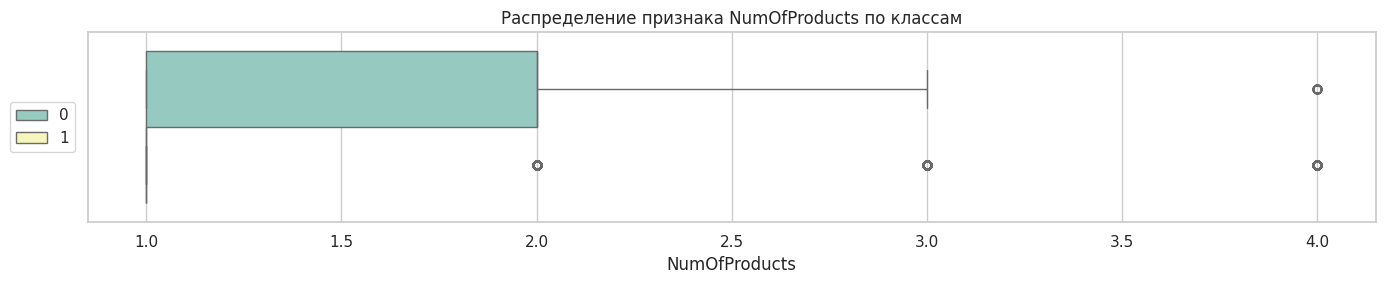

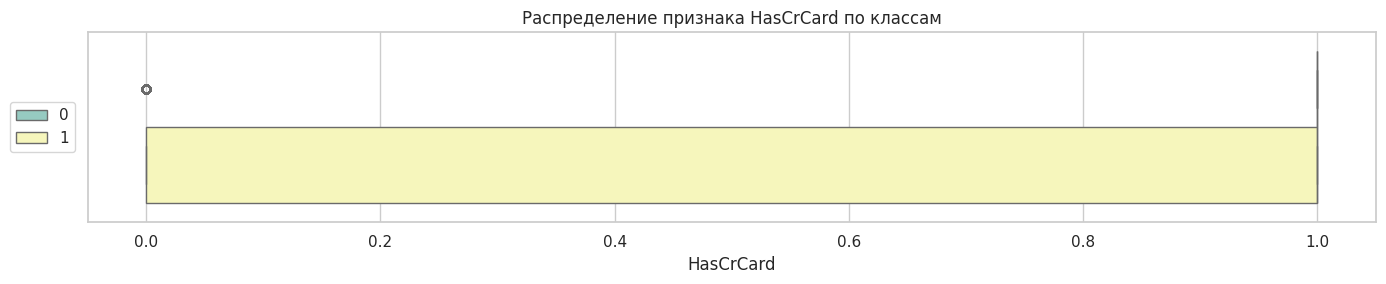

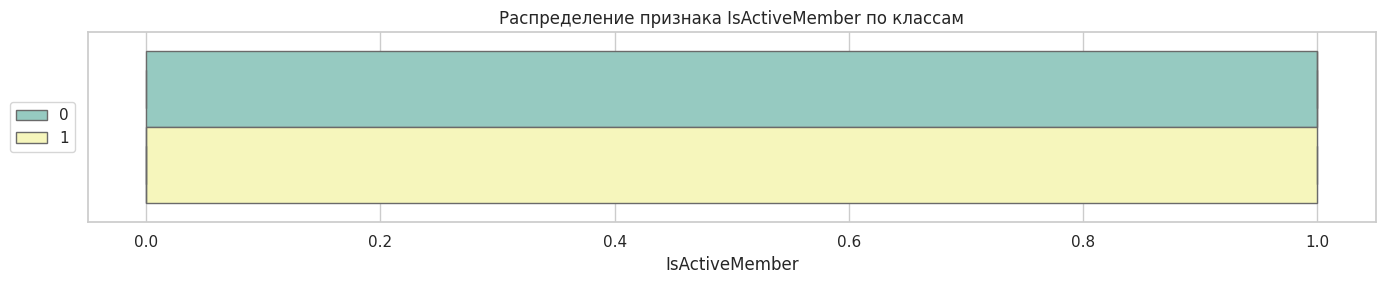

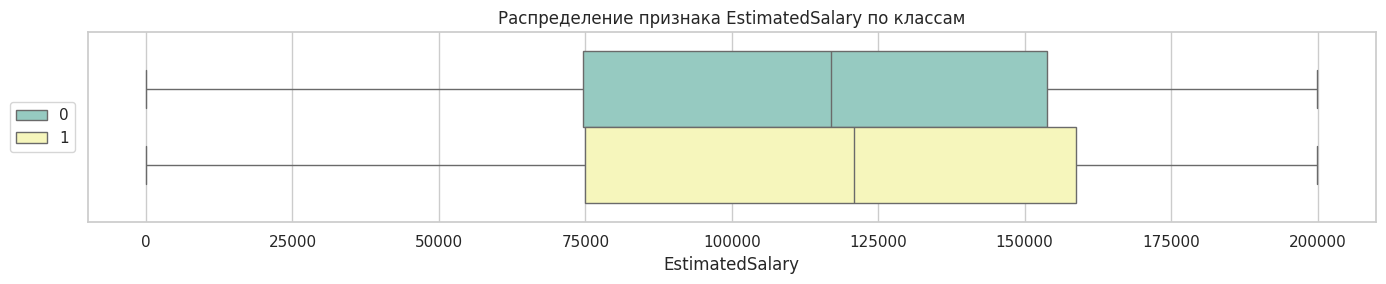

In [18]:
sns.set(style='whitegrid')

for col in num_cols:
    plt.figure(figsize=(14, 3))
    sns.boxplot(data=train, x=col, hue='Exited', palette='Set3', legend=True)
    plt.title(f'Распределение признака {col} по классам')
    # Перемещаем легенду в левую часть и центрируем по высоте
    plt.legend(bbox_to_anchor=(-0.01, 0.5), loc='center right', borderaxespad=0)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [19]:
# Поиск выбросов с помощью IQR, но возьмет 2 IQR как более щадящую границу

Q1 = X_train[num_cols].quantile(0.25)
Q3 = X_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Создаём DataFrame с флагами выбросов (True/False)
outlier_flags_train = (X_train[num_cols] < (Q1 - 2 * IQR)) | (X_train[num_cols] > (Q3 + 2 * IQR))

# Пример: вывести % выбросов по колонкам
outlier_percent = outlier_flags_train.mean().sort_values(ascending=False)
print("Процент выбросов по признакам:")
outlier_percent

Процент выбросов по признакам:


,0
HasCrCard,0.246397
Age,0.016701
CreditScore,0.000235
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000
IsActiveMember,0.000000
EstimatedSalary,0.000000


In [20]:
# HasCrCard - это бинарный признак в нем не может быть выбросов,
# удалим выбросы из признаков Age и CreditScore и сохраним в отдельный ДФ для опытов

X_train_out = X_train[~outlier_flags_train[['Age', 'CreditScore']].any(axis=1)]
y_train_out = y_train[~outlier_flags_train[['Age', 'CreditScore']].any(axis=1)]
X_valid_out = X_valid.copy()

# Сделам из У серию
y_valid = y_valid['Exited']
y_train = y_train['Exited']
y_train_out = y_train_out['Exited']

X_train_out.shape

(129791, 12)

## Анализ и обработка пропусков

In [21]:
X_train.isna().sum()

,0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0
HasCrCard,0.0


In [22]:
# На всем датасете

df.isna().sum()

,0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0
HasCrCard,0.0


#### Нам повезло: датасет не имеет пропусков!

## Анализ и обработка категориальных переменных

In [23]:
# Кодируем категориальные признаки OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train[cat_cols])
X_valid_encoded = encoder.transform(X_valid[cat_cols])

# Получаем названия новых колонок
enc_col_names = encoder.get_feature_names_out(cat_cols)

# Преобразуем в DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=enc_col_names, index=X_train.index)
X_valid_encoded_df = pd.DataFrame(X_valid_encoded, columns=enc_col_names, index=X_valid.index)

## Масштабирование числовых признаков

In [24]:
# Т.к. у нас есть выбросы, попробуем RobustScaler, как более устойчивый к выбросам


# scaler = StandardScaler()
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])

# Добавляем закодированные категориальные колонки
X_train = pd.concat([X_train[num_cols], X_train_encoded_df], axis=1)
X_valid = pd.concat([X_valid[num_cols], X_valid_encoded_df], axis=1)

print("Размерности после кодирования:")
print(f"X_train: {X_train.shape}, X_test: {X_valid.shape}")

Размерности после кодирования:
X_train: (132027, 11), X_test: (33007, 11)


# <font color='#11a642' size='6'> **Построение моделей машинного обучения**

In [25]:
def find_optimal_threshold(y_true, y_proba):
    # Функция для подбора оптимального порога
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Вычисляем F1-score для каждого порога
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    # Находим порог с максимальным F1
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def show_roc_auc(model):
    # Получение вероятностей
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]

    # Подбираем порог на валидационной выборке
    optimal_threshold = find_optimal_threshold(y_valid, y_valid_proba)
    print(f"Оптимальный порог: {optimal_threshold:.4f}")
    # Применяем порог к обеим выборкам
    y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
    y_valid_pred = (y_valid_proba >= optimal_threshold).astype(int)

    # ROC-кривая + AUC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    # roc_auc_score
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_valid = roc_auc_score(y_valid, y_valid_proba)
    # Расчёт F1-score
    f1_train = f1_score(y_train, y_train_pred)
    f1_valid = f1_score(y_valid, y_valid_pred)
    # Построение ROC-графика
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.5f})", color="blue")
    plt.plot(fpr_valid, tpr_valid, label=f"Valid ROC (AUC = {auc_valid:.5f})", color="green")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая: Train vs Valid")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return f1_train, f1_valid, auc_train, auc_valid

## <font color='#11a642' size='5'> Построение логистической регрессии

Оптимальный порог: 0.3196


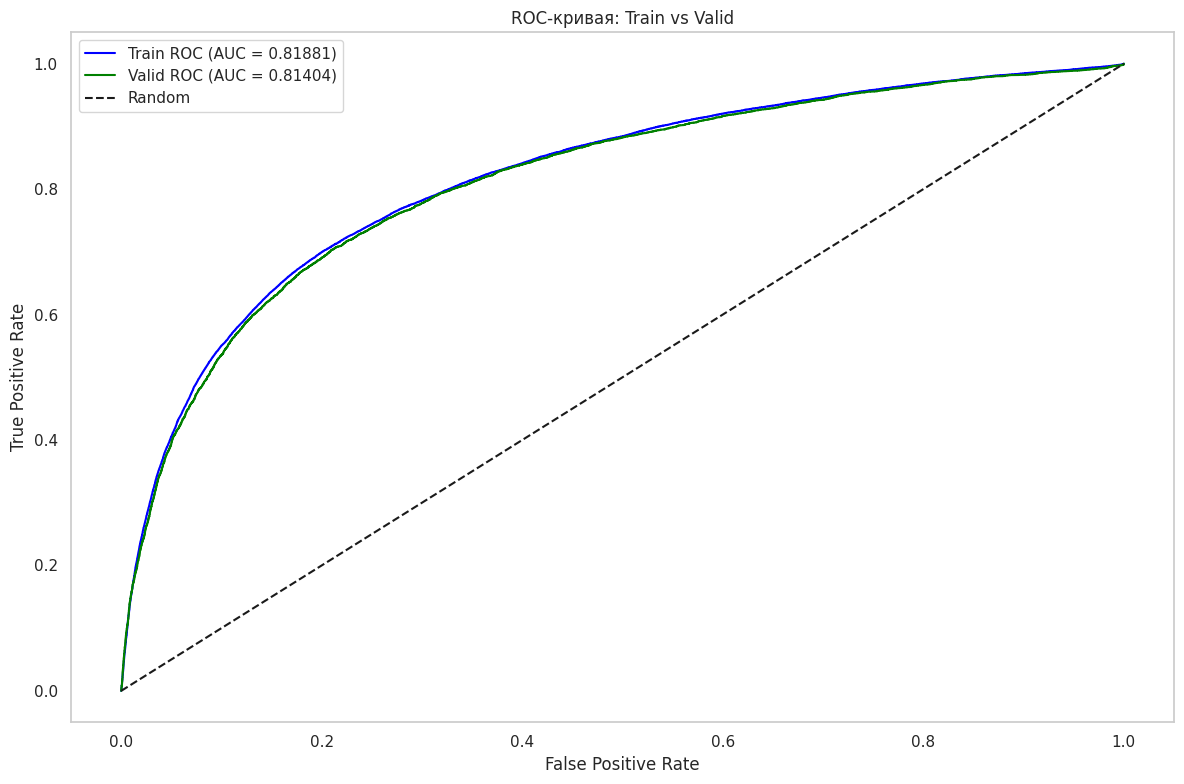

In [26]:
# Обучение логистической регрессии
logreg1 = LogisticRegression(max_iter=1000, random_state=127)
logreg1.fit(X_train, y_train)

res1 = show_roc_auc(logreg1)

## <font color='#11a642' size='5'> Построение логистической регрессии с регуляризацией
> можно использовать [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), настроив гиперпараметры penalty и C

In [27]:
%%time
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 5, 10],
    'solver': ['saga', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=2000),
                    params,
                    scoring='f1',
                    cv=5)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: user 1min 13s, sys: 624 ms, total: 1min 13s
Wall time: 1min 15s


Оптимальный порог: 0.3185


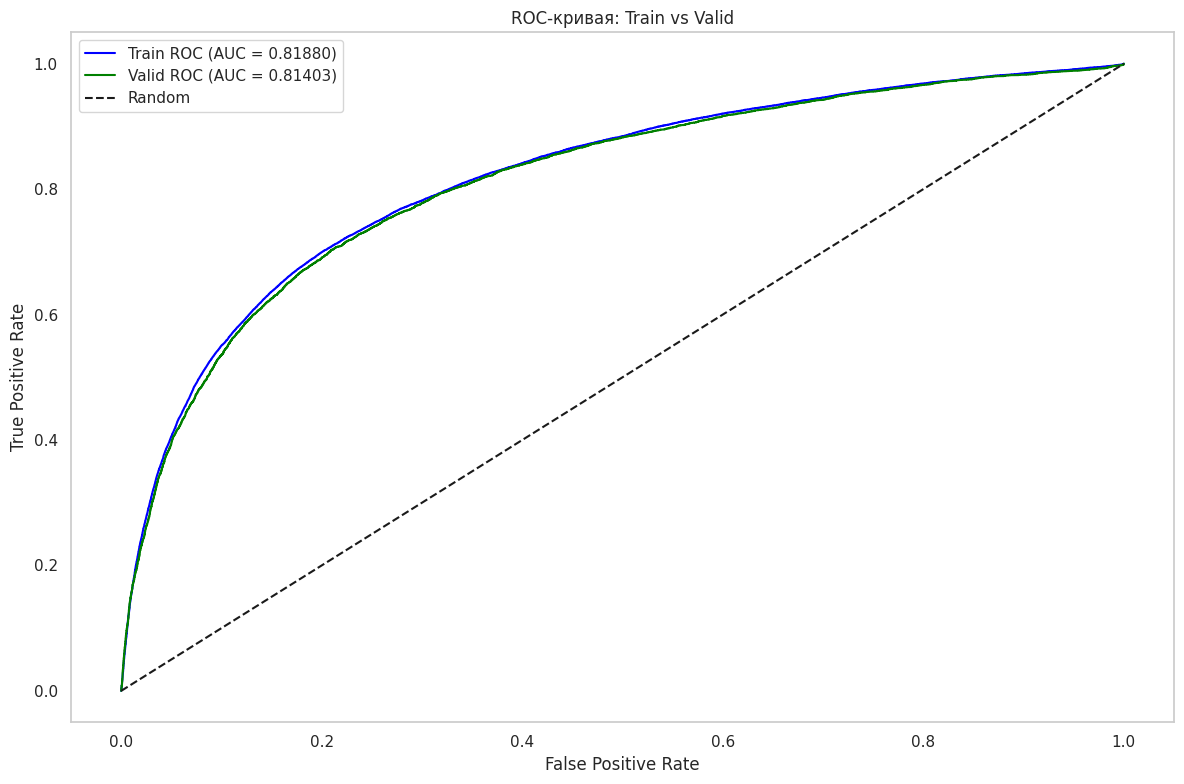

In [28]:
logreg2 = LogisticRegression(**grid.best_params_)
logreg2.fit(X_train, y_train)

res2 = show_roc_auc(logreg2)

In [29]:
# Создадим ДФ из метрик моделей
result = pd.DataFrame((res1, res2),
                      columns=['F1 Train', 'F1 Valid', 'AUC Train', 'AUC Valid'],
                      index=['LogisticRegression', 'LogisticRegression_GridSearchCV'])
result

,F1 Train,F1 Valid,AUC Train,AUC Valid
LogisticRegression,0.578359,0.573976,0.818806,0.814037
LogisticRegression_GridSearchCV,0.578442,0.573893,0.818802,0.814033


На валидации модель LogisticRegression показала, лучший результат, чем с подобранными параметрами penalty и C.

Однако при использовании StandardScaler были получены противоположные результаты (модель с подобранными гиперпараметрами выдала лучше результат)
|Модель	|F1 Valid|	AUC Valid|
|-|-|-|
|LogisticRegression|	0.573898|	0.814034|
|LogisticRegression_GridSearchCV	|0.573951|	0.814036|


### Попробуем обучить модель с удаленными выбросами из трейна

In [30]:
# Кодируем категориальные признаки OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train_out[cat_cols])
X_valid_encoded = encoder.transform(X_valid_out[cat_cols])

# Получаем названия новых колонок
enc_col_names = encoder.get_feature_names_out(cat_cols)

# Преобразуем в DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=enc_col_names, index=X_train_out.index)
X_valid_encoded_df = pd.DataFrame(X_valid_encoded, columns=enc_col_names, index=X_valid_out.index)

# Масштабирование признаков
# scaler = StandardScaler()
scaler = RobustScaler()
X_train_out[num_cols] = scaler.fit_transform(X_train_out[num_cols])
X_valid_out[num_cols] = scaler.transform(X_valid_out[num_cols])

# Добавляем закодированные категориальные колонки
X_train = pd.concat([X_train_out[num_cols], X_train_encoded_df], axis=1)
X_valid = pd.concat([X_valid_out[num_cols], X_valid_encoded_df], axis=1)

y_train = y_train_out # Чтобы использовать функцию отрисофки графика

print("Размерности после кодирования:")
print(f"X_train: {X_train.shape}, X_test: {X_valid.shape}")

Размерности после кодирования:
X_train: (129791, 11), X_test: (33007, 11)


Оптимальный порог: 0.2859


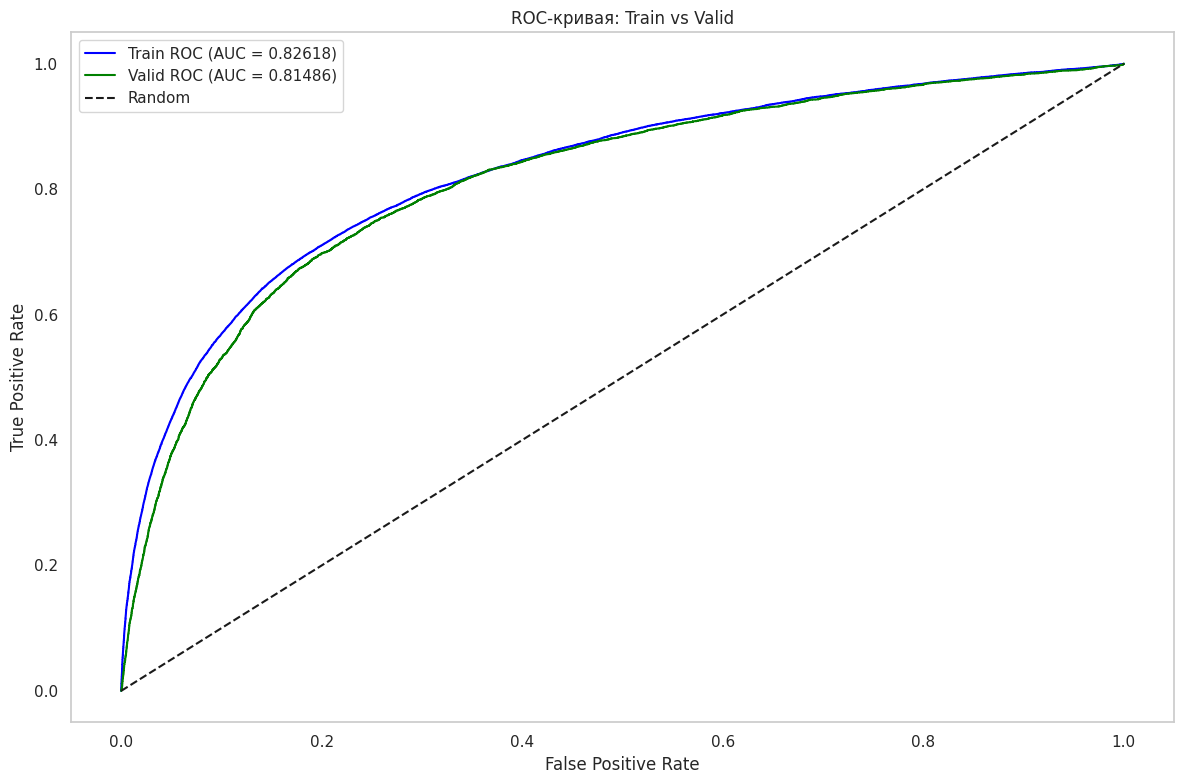

In [31]:
logreg3 = LogisticRegression()
logreg3.fit(X_train, y_train)

result.loc['LogisticRegression_outlets'] = show_roc_auc(logreg3)

In [32]:
%%time
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 5, 10],
    'solver': ['saga', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=2000),
                    params,
                    scoring='f1',
                    cv=5)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)

logreg4 = LogisticRegression(**grid.best_params_)
logreg4.fit(X_train, y_train)

Лучшие параметры: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
CPU times: user 1min 27s, sys: 144 ms, total: 1min 28s
Wall time: 1min 36s


LogisticRegression(C=10, penalty='l1', solver='saga')

Оптимальный порог: 0.2862


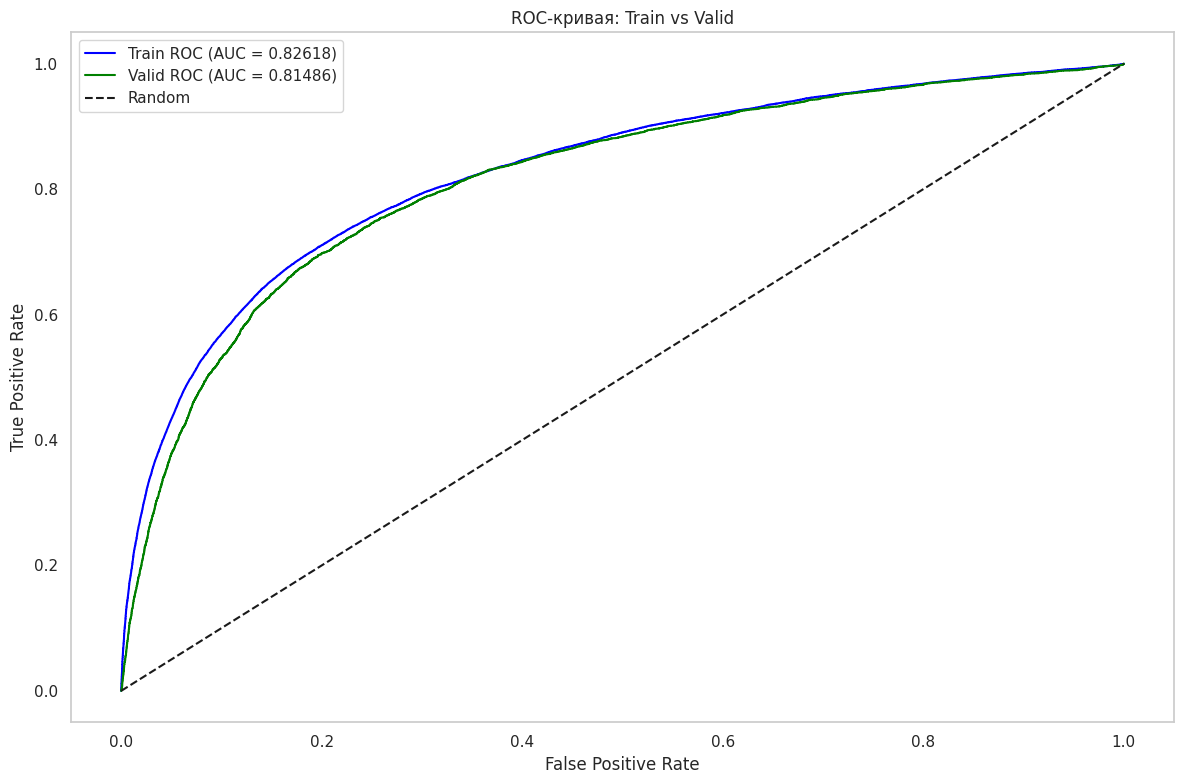

In [33]:
result.loc['LogisticRegression_outlets_GridSearchCV'] = show_roc_auc(logreg4)

In [34]:
result

,F1 Train,F1 Valid,AUC Train,AUC Valid
LogisticRegression,0.578359,0.573976,0.818806,0.814037
LogisticRegression_GridSearchCV,0.578442,0.573893,0.818802,0.814033
LogisticRegression_outlets,0.590258,0.577809,0.826180,0.814859
LogisticRegression_outlets_GridSearchCV,0.590257,0.577848,0.826176,0.814857


### <font color='#11a642' size='4'> Оценка качества  всех моделей


In [35]:
for col in result.columns:
    print(f'Метрика: {col:>10} --> лучшая модель: {result[col].idxmax()}')

Метрика:   F1 Train --> лучшая модель: LogisticRegression_outlets
Метрика:   F1 Valid --> лучшая модель: LogisticRegression_outlets_GridSearchCV
Метрика:  AUC Train --> лучшая модель: LogisticRegression_outlets
Метрика:  AUC Valid --> лучшая модель: LogisticRegression_outlets


# <font color='#11a642' size='4'> Ваши выводы
- какую из моделей вы рекомендуете использовать для прогноза? Почему?



Исходя из полученных результатов по метрикам F1 и AUC (на тренировочной и валидационной выборках), можно сделать следующие выводы:

📊 Сравнение моделей:

|Модель	|F1 Valid|	AUC Valid|
|-|-|-|
|LogisticRegression|	0.573976|	0.814037|
|LogisticRegression_GridSearchCV|	0.573873|	0.814034|
|LogisticRegression_outlets|0.577809|**0.814859**|
|LogisticRegression_outlets_GridSearchCV|	**0.577811**|	0.814858|

    F1 Valid — самая высокая у модели LogisticRegression_outlets_GridSearchCV, что говорит о более сбалансированном соотношении precision и recall на валидации.

    AUC Valid — максимальный у модели LogisticRegression_outlets, но сопоставимый с моделью LogisticRegression_outlets_GridSearchCV, что означает лучшую общую способность различать классы.

⚖️ Заключение:

Модель LogisticRegression_outlets_GridSearchCV (на тренировочных данных были удалены выбросы, со значениями более 2-х межквартильных размахов с подбором параметров penalty и C) показывает наилучший баланс между точностью и обобщающей способностью. Даже если прирост кажется небольшим, при прочих равных условиях её стоит предпочесть другим моделям, т.к. у неё меньший разрым между метриками на тренировке и валидации, т.е. она менее переобучена, чем модель с параметрами по умолчанию.